In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import cv2
from tqdm import tqdm

In this mini Kaggle project - we are predicting whether an image of tissue contains histopathologic cancer cells.
<br>The Kaggle competition is the following https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview<br>We are given a very large database of images of medical scans with and without cancer cells.<br>What we need to do is explore and clean this data, and then apply Convolutional Neural Networks to it - our solution needs to predict whether an image contains cancer or not.<br>In the end of the mini project, we submit our solution to Kaggle.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Load labels
df = pd.read_csv("train_labels.csv")
print("Total images:", len(df))
print(df.label.value_counts())
df.head()

Total images: 220025
label
0    130908
1     89117
Name: count, dtype: int64


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


After loading the data, we visualize the distribution of yes/no for "does this cell have cancer".<br>As the distribution is skewed, we need to balance it.

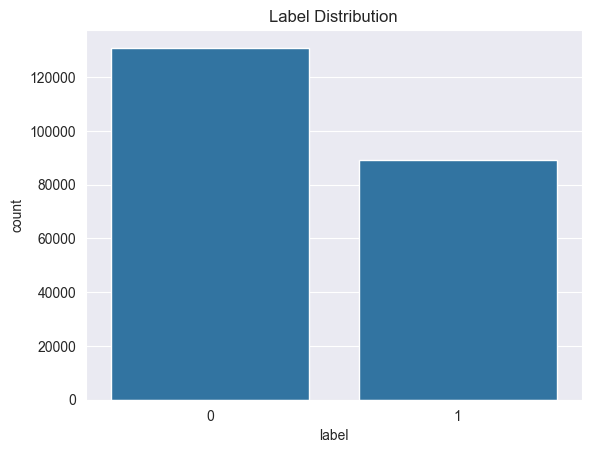

In [ ]:
# Visualize class distribution
sns.countplot(data=df, x='label')
plt.title('Label Distribution')
plt.show()

In [ ]:
df.duplicated().sum()

np.int64(0)

There are no duplicates in data, so we don't handle that. Let us explore what the images look like, and balance our dataframe.

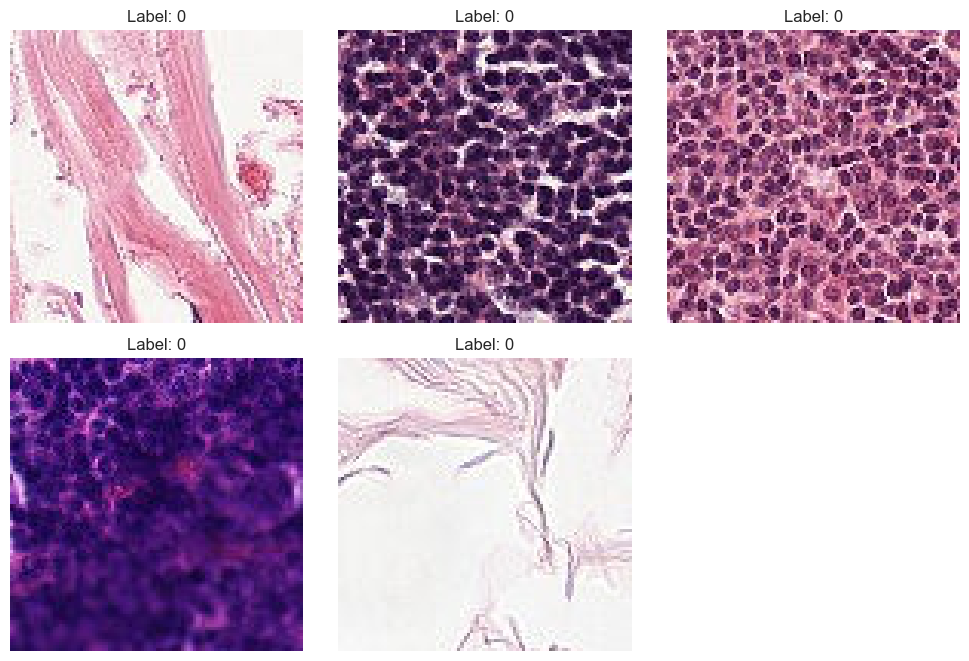

In [ ]:
imgs = df[df['label'] == 0]['id'].sample(5).values
plt.figure(figsize=(10, 10))
for i, img_id in enumerate(imgs):
    img = cv2.imread(f'train/{img_id}.tif')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Label: 0')
plt.tight_layout()
plt.show()

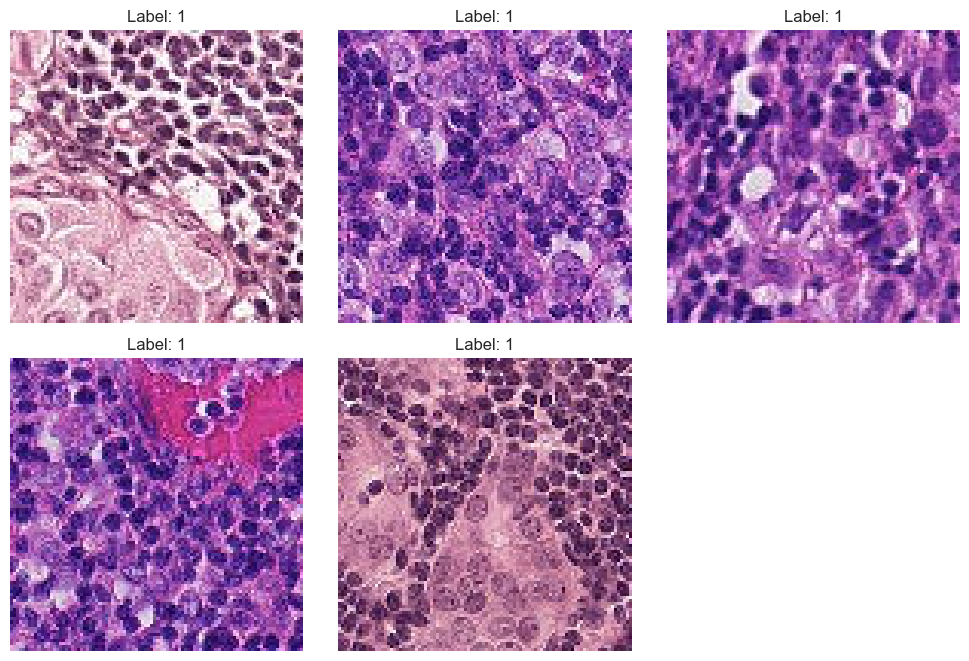

In [ ]:
    imgs = df[df['label'] == 1]['id'].sample(5).values
    plt.figure(figsize=(10, 10))
    for i, img_id in enumerate(imgs):
        img = cv2.imread(f'train/{img_id}.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Label: 1')
    plt.tight_layout()
    plt.show()

In [ ]:
min_count = df.label.value_counts().min()
df_balanced = pd.concat([
    df[df.label == 0].sample(min_count, random_state=42),
    df[df.label == 1].sample(min_count, random_state=42)
])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced

,id,label
0,84e2de905656d96a8f1894aa493db4dd18c67739,1
1,3e4291d96c6b4320168347bda92e7ba33b18ff91,0
2,478978eb822013bd3e58f49a75cd7b95a9a66199,0
3,8e9686c7d13147456245ffc0354f9bf739eac56d,0
4,4dbc87d82d0e7810d946fc4b20cae62d5713e5ea,1
...,...,...
178229,e60c3abcf4ffc619b9b9d4be2c17b1836caa2963,1
178230,8ac241d257da3365c1185980143d7722725dfd4e,1
178231,3a3006bc1da5eabf98bb92216d428f7ba68b119d,1
178232,ece73a6752a3f715b53a962ecce3fe1ce27a661d,1


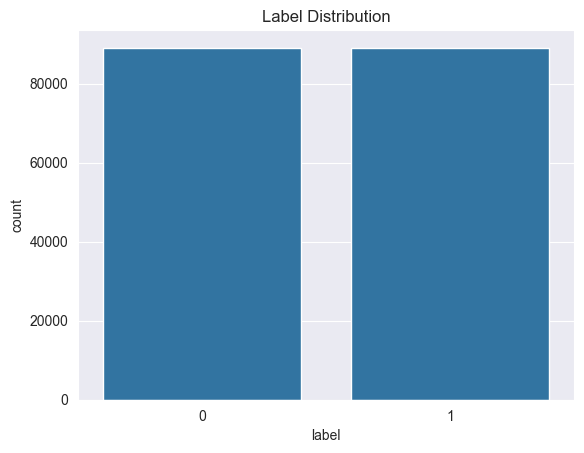

In [ ]:
# Visualize balanced data distribution
sns.countplot(data=df_balanced, x='label')
plt.title('Label Distribution')
plt.show()

After this we have a balanced dataset, and we just need a minor modification for easier processing - include the filename .tif in the id column.

In [ ]:
df_balanced['label'] = df_balanced['label'].apply(lambda x: str(x))
df_balanced['id'] = df_balanced['id'].apply(lambda x: x + '.tif')

I was not able to get a GPU working for this mini project - so included fewer trained models than it would have been possible. There are examples in the notebook of how hyperparameters are being tuned - but for the submission, only two distinct architectures without tuning were used.

In [ ]:
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


2.19.0
Num GPUs Available: 0


Here we make a train test split and create a generator instance for image data to be able to feed our images into the model.

In [ ]:
# Train/val split
train_df, val_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced.label, random_state=42)


In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_dataframe(
    train_df, directory='train', x_col='id', y_col='label',
    target_size=(96, 96), class_mode='binary', batch_size=32)
val_gen = datagen.flow_from_dataframe(
    val_df, directory='train', x_col='id', y_col='label',
    target_size=(96, 96), class_mode='binary', batch_size=32)


Found 142587 validated image filenames belonging to 2 classes.
Found 35647 validated image filenames belonging to 2 classes.


Demonstration of two architectures used for the mini project:
 - Basic CNN - has a CNN with flattening and dropout, at the end we have a sigmoid predicting a binary yes/no output
 - 2 CNN - a 2 layer CNN with twice as many filters on the second CNN layer, and the same ending layers

 WE build models for a grid search of filter count and dropout parameters and store them in a model list.

In [ ]:
def build_model_basic_cnn(filters, drpo):
    model = Sequential([
        Conv2D(filters, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(drpo),
        Dense(1, activation='sigmoid')
    ])
    return model

cnn_models = []
for filter_cnt in {32, 64}:
    for dropout in {0, 0.25, 0.5, 0.75}:
        cnn_models.append(build_model_basic_cnn(filter_cnt, dropout))

C:\Users\Momcilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def build_model_2_cnn(filters_cnt, drpo):
    model = Sequential([
        Conv2D(filters_cnt, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(filters_cnt*2, (3, 3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(drpo),
        Dense(1, activation='sigmoid')
    ])
    return model

cnn_2layer_models = []
for filter_cnt in {32, 64}:
    for dropout in {0, 0.25, 0.5, 0.75}:
        cnn_2layer_models.append(build_model_2_cnn(filter_cnt, dropout))

C:\Users\Momcilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
for idx, model in enumerate(cnn_models + cnn_2layer_models):
    print(f"\nTraining Model {idx + 1}...")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[es])
    histories.append(history)

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Model {idx + 1} Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Model {idx + 1} Loss')
    plt.legend()
    plt.show()

This is a definition and running of  these two models with set hyperparameters, as we have only been able to run that on CPU.


Training Model 1...
Epoch 1/10


C:\Users\Momcilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4456/4456 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6844 - loss: 0.6033

C:\Users\Momcilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4456/4456 ━━━━━━━━━━━━━━━━━━━━ 307s 69ms/step - accuracy: 0.6844 - loss: 0.6032 - val_accuracy: 0.7937 - val_loss: 0.4690
Epoch 2/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 274s 61ms/step - accuracy: 0.7724 - loss: 0.4968 - val_accuracy: 0.8089 - val_loss: 0.4447
Epoch 3/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 272s 61ms/step - accuracy: 0.7836 - loss: 0.4769 - val_accuracy: 0.8005 - val_loss: 0.4585
Epoch 4/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 260s 58ms/step - accuracy: 0.7951 - loss: 0.4550 - val_accuracy: 0.8003 - val_loss: 0.4273
Epoch 5/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 267s 60ms/step - accuracy: 0.8030 - loss: 0.4408 - val_accuracy: 0.8056 - val_loss: 0.4284
Epoch 6/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 349s 78ms/step - accuracy: 0.8090 - loss: 0.4290 - val_accuracy: 0.8123 - val_loss: 0.4210
Epoch 7/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 412s 92ms/step - accuracy: 0.8182 - loss: 0.4108 - val_accuracy: 0.8096 - val_loss: 0.4279
Epoch 8/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 319s 65ms/step - accuracy: 0.8286 - lo

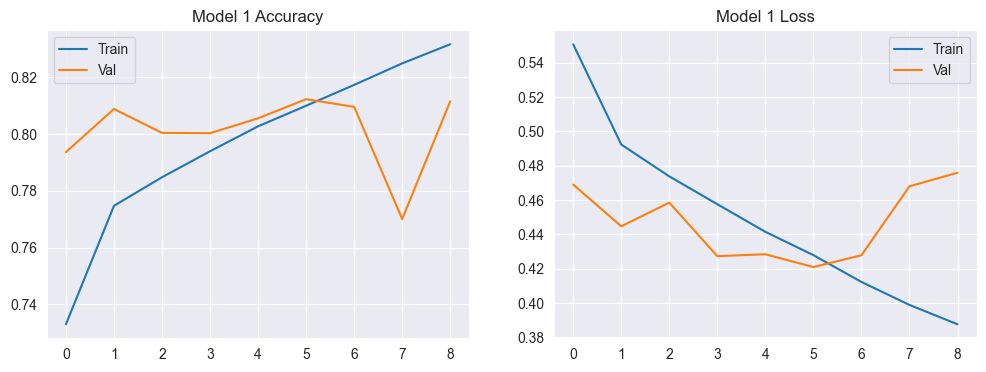


Training Model 2...
Epoch 1/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 779s 174ms/step - accuracy: 0.7925 - loss: 0.5260 - val_accuracy: 0.8311 - val_loss: 0.4196
Epoch 2/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 693s 155ms/step - accuracy: 0.8464 - loss: 0.3681 - val_accuracy: 0.8309 - val_loss: 0.3923
Epoch 3/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 661s 148ms/step - accuracy: 0.8655 - loss: 0.3252 - val_accuracy: 0.8664 - val_loss: 0.3235
Epoch 4/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 719s 157ms/step - accuracy: 0.8748 - loss: 0.2977 - val_accuracy: 0.8667 - val_loss: 0.3203
Epoch 5/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 637s 143ms/step - accuracy: 0.8871 - loss: 0.2721 - val_accuracy: 0.8688 - val_loss: 0.3171
Epoch 6/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 698s 147ms/step - accuracy: 0.8981 - loss: 0.2496 - val_accuracy: 0.8224 - val_loss: 0.5055
Epoch 7/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 663s 142ms/step - accuracy: 0.9080 - loss: 0.2279 - val_accuracy: 0.8534 - val_loss: 0.3986
Epoch 8/10
4456/4456 ━━━━━━━━━━━━━━━━━━━━

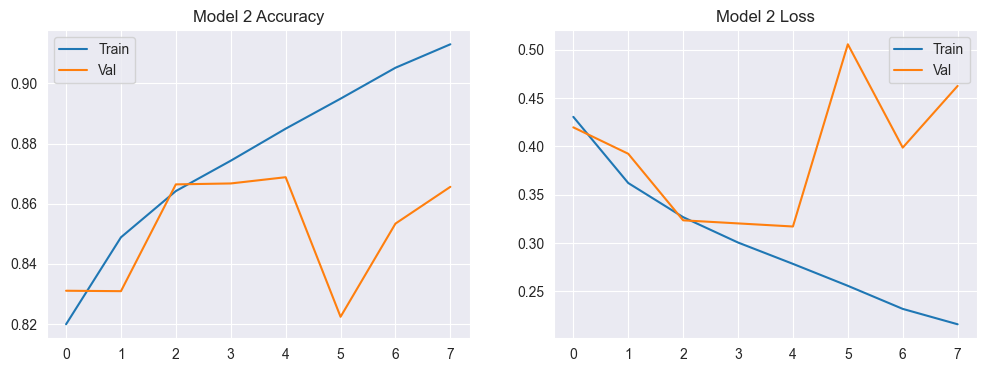

Found 57458 validated image filenames.
   15/57458 ━━━━━━━━━━━━━━━━━━━━ 4:19 5ms/step    

C:\Users\Momcilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 535s 9ms/step
Submission file saved as submission.csv


In [ ]:


# Define multiple models
def build_model_1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_model_2():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Train and evaluate models
models = [build_model_1(), build_model_2()]
histories = []

for idx, model in enumerate(models):
    print(f"\nTraining Model {idx + 1}...")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[es])
    histories.append(history)

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Model {idx + 1} Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'Model {idx + 1} Loss')
    plt.legend()
    plt.show()



We can actually see on the plots that the validation accuracies are quite good. The moment the val score intersects the train score, and the train increases but the validation decreases is when we see overfitting - this is roughly the best validation score we can get. For the first model, that is ~0.81 and for the second ~0.87, so we choose the second to generate our output data.

We list all our test dir files in our test_df, and load their data.<br>After this, we save all labels, and funnily reload to remove the .tif...

In [ ]:
file_list = os.listdir('test/')

test_df = pd.DataFrame({'id': file_list})
test_df

,id
0,00006537328c33e284c973d7b39d340809f7271b.tif
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,000270442cc15af719583a8172c87cd2bd9c7746.tif
...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53.tif
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3.tif
57455,fffec7da56b54258038b0d382b3d55010eceb9d7.tif
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6.tif


In [ ]:
# Model 2 turns out to be the best
best_model = models[-1]
test_gen = datagen.flow_from_dataframe(
    test_df, directory='test', x_col='id', y_col=None,
    target_size=(96, 96), class_mode=None, batch_size=1, shuffle=False)

preds = best_model.predict(test_gen, verbose=1)
test_df['label'] = (preds > 0.5).astype(int)

# Save submission
test_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Found 57458 validated image filenames.
    6/57458 ━━━━━━━━━━━━━━━━━━━━ 9:44 10ms/step   

C:\Users\Momcilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 494s 9ms/step
Submission file saved as submission.csv


In [ ]:
test_df = pd.read_csv("submission.csv")
test_df["id"] = test_df["id"].apply(lambda x: x[:-4])

test_df

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0


In [ ]:
test_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv


And here we see our score on the Kaggle leaderboard!
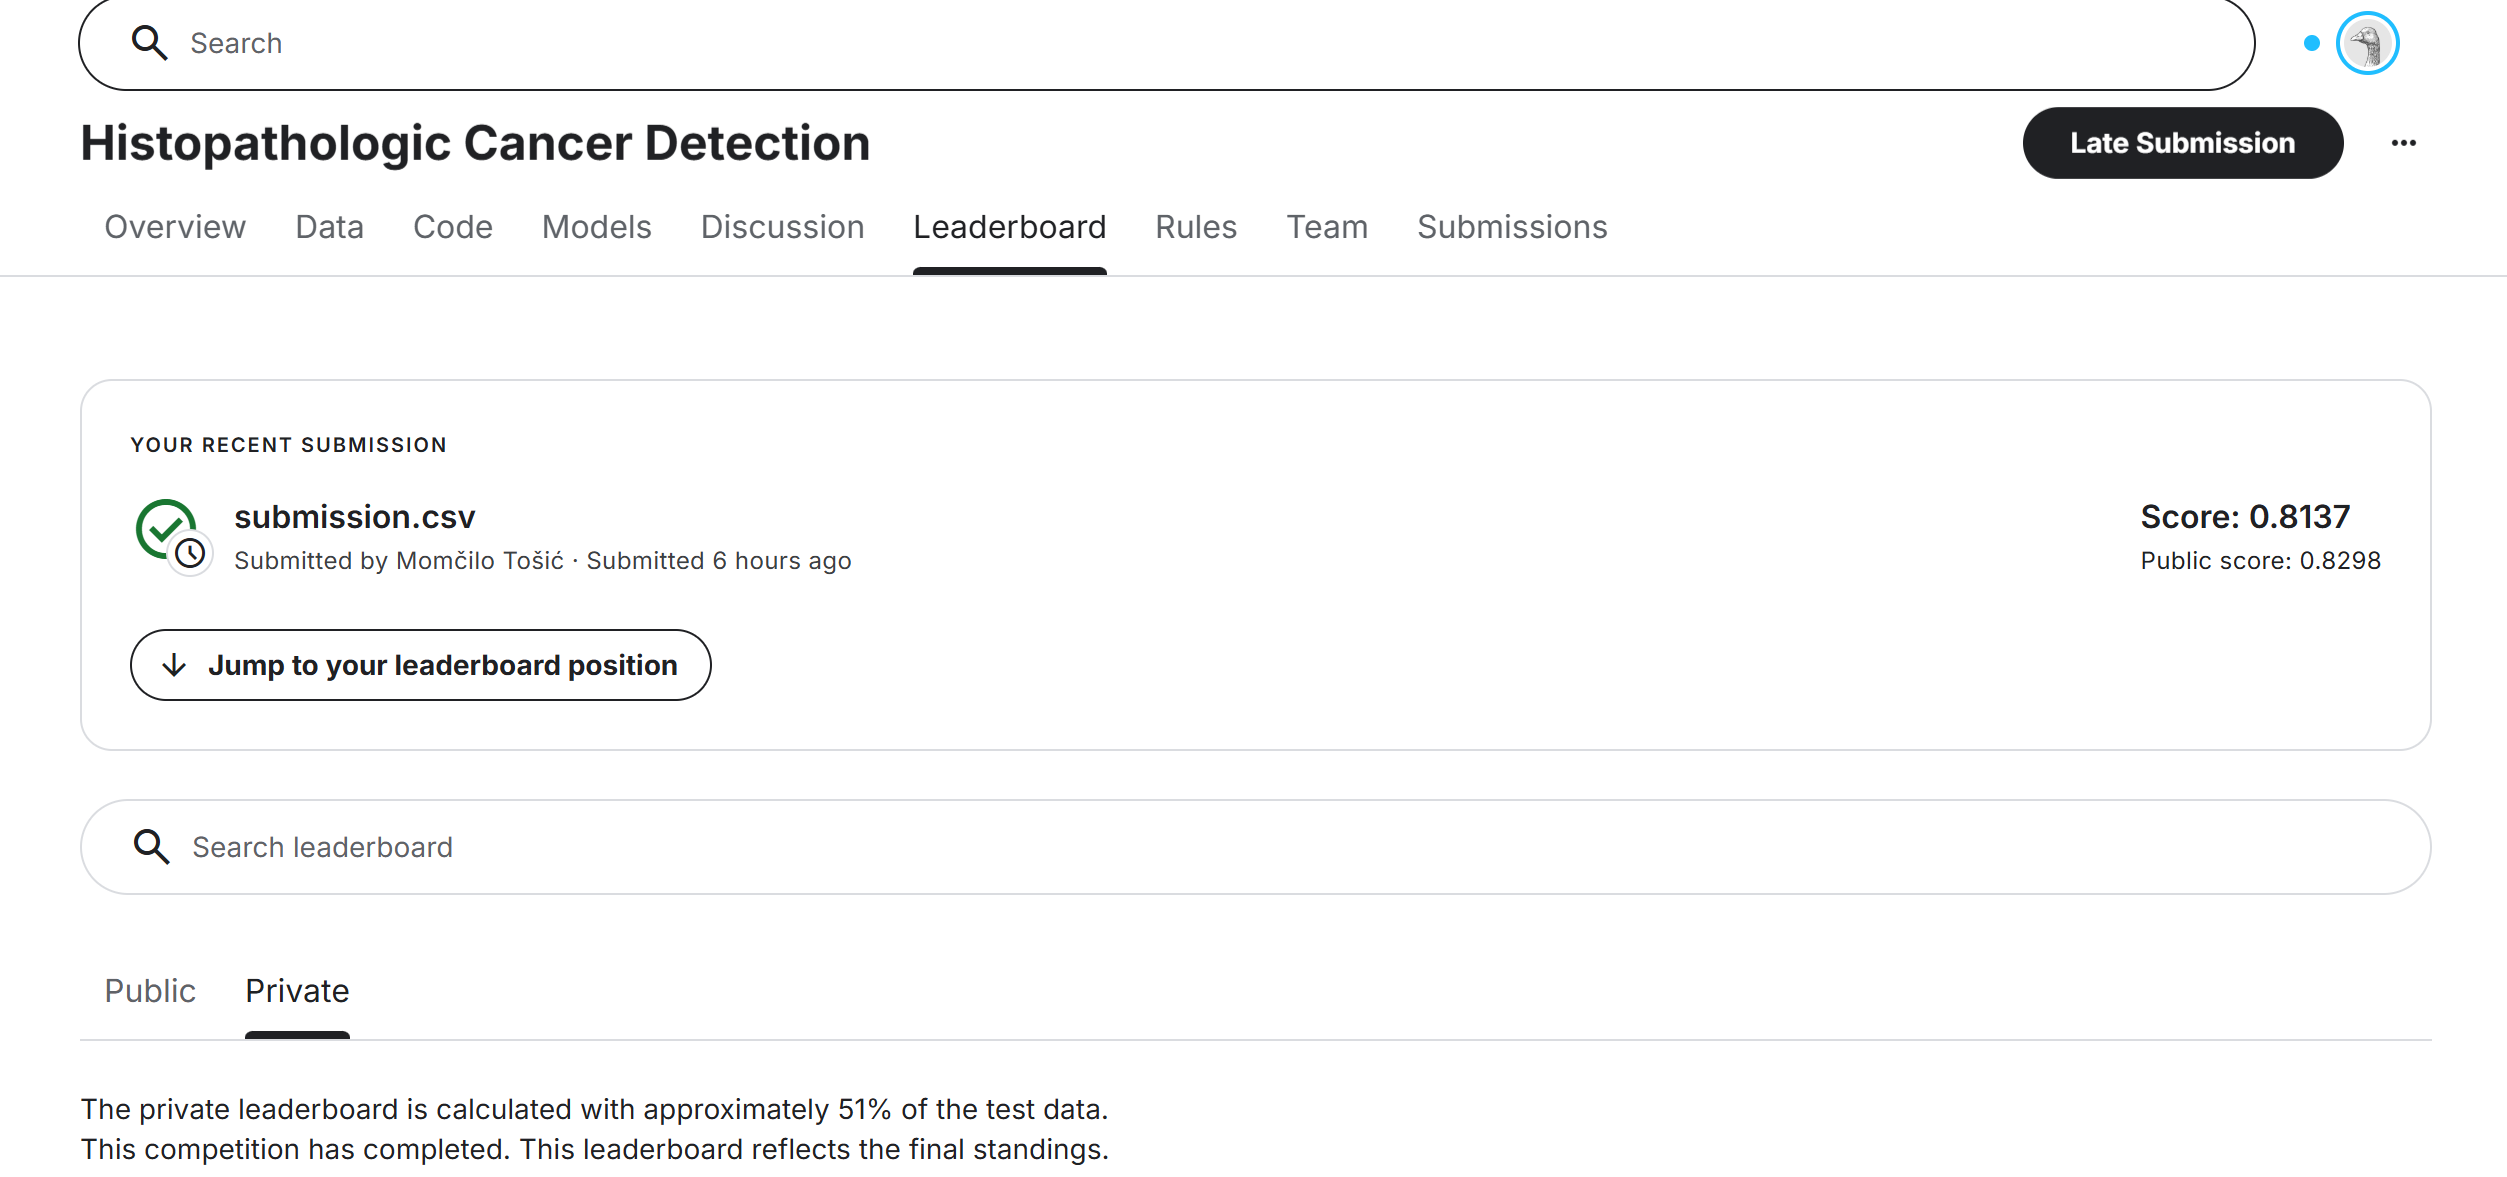